In [1482]:
# Prepare train-test split of the generated data
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/incident_root_cause_data.csv")

df['root_cause_numeric'] = df['root_cause_label'].astype('category').cat.codes
X = df.drop(columns=["root_cause_label"])
y = df["root_cause_numeric"]
print(df[["root_cause_label", "root_cause_numeric"]].head(100))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


               root_cause_label  root_cause_numeric
0                cpu_saturation                   1
1                        normal                   4
2                        normal                   4
3                        normal                   4
4                bad_deployment                   0
..                          ...                 ...
95                traffic_spike                   5
96  external_dependency_failure                   2
97                  memory_leak                   3
98  external_dependency_failure                   2
99  external_dependency_failure                   2

[100 rows x 2 columns]


In [1483]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Build a baseline logistic regression model pipeline with standard scaling
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])

# Fit the model to the training data
logreg_pipeline.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred_lr = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_lr))



/Users/swethachakravarthy/Projects/incident-intelligence/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      0.99      1.00       115
           2       1.00      0.99      1.00       108
           3       0.99      0.98      0.99       116
           4       0.99      1.00      0.99       237
           5       1.00      1.00      1.00       108

    accuracy                           0.99       800
   macro avg       1.00      0.99      1.00       800
weighted avg       1.00      0.99      0.99       800



In [1484]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       115
           2       0.99      1.00      1.00       108
           3       1.00      0.99      1.00       116
           4       1.00      1.00      1.00       237
           5       1.00      1.00      1.00       108

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [1485]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


root_cause_numeric     0.460135
memory_growth_rate     0.169373
error_rate             0.125378
upstream_error_rate    0.091827
request_rate           0.061724
avg_cpu_usage          0.052528
dependency_latency     0.020646
oom_log_count          0.013740
timeout_log_count      0.002465
latency                0.002184
dtype: float64

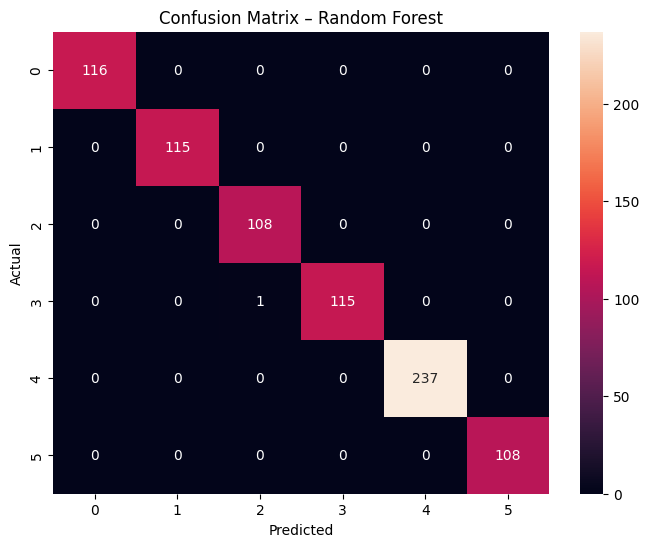

In [1486]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=rf.classes_,
            yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()


In [1488]:
df.groupby("root_cause_label")["oom_log_count"].describe()

,count,mean,std,min,25%,50%,75%,max
root_cause_label,,,,,,,,
bad_deployment,581.0,0.538726,0.740897,0.0,0.0,0.0,1.0,4.0
cpu_saturation,577.0,1.568458,1.456276,0.0,0.0,1.0,2.0,7.0
external_dependency_failure,539.0,0.504638,0.696164,0.0,0.0,0.0,1.0,4.0
memory_leak,579.0,2.822107,1.791308,0.0,2.0,3.0,4.0,10.0
normal,1182.0,0.505922,0.696829,0.0,0.0,0.0,1.0,4.0
traffic_spike,542.0,1.476015,1.361735,0.0,0.0,1.0,2.0,6.0
